In [1]:
import pandas as pd 
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
from nltk.tokenize import word_tokenize

In [3]:
import tensorflow as tf

2022-09-19 09:30:08.901949: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


In [4]:
tf.test.is_built_with_cuda()

True

In [5]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold

from sklearn.feature_extraction.text import TfidfVectorizer

In [6]:
TRAIN_PATH = 'data/train.csv'
TEST_PATH = 'data/test.csv'
SAMPLE_SUBMISSION = 'data/sample_submission.csv'
RANDOM_STATE = 25

In [7]:
FEATURE_COLUMNS = ['full_text']
TARGET_COLUMNS = ['cohesion', 'syntax','vocabulary', 'phraseology', 'grammar','conventions']

In [8]:
train = pd.read_csv(TRAIN_PATH)
test = pd.read_csv(TEST_PATH)

In [9]:
# Chollet transformer heuristic
# S = number of samples / mean number of words per sample
# if S > 1500 --> Sequence model
# else --> bag-of-bigrams

tokenized_sentences = train.full_text.map(word_tokenize)
mean_number_of_tokens = tokenized_sentences.map(len).mean().round()
S = train.shape[0] / mean_number_of_tokens
S

8.321276595744681

In [10]:
train.shape, test.shape

((3911, 8), (3, 2))

In [11]:
test.head()

,text_id,full_text
0,0000C359D63E,when a person has no experience on a job their...
1,000BAD50D026,Do you think students would benefit from being...
2,00367BB2546B,"Thomas Jefferson once states that ""it is wonde..."


In [12]:
def MCRMSE(y_true, y_pred):
    colwise_mse = tf.reduce_mean(tf.square(y_true - y_pred), axis=0)
    return tf.reduce_mean(tf.sqrt(colwise_mse), axis=0)

In [13]:
X, Y = train[FEATURE_COLUMNS], train[TARGET_COLUMNS]
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=.2)

X_valid, X_test, Y_valid, Y_test = train_test_split(X_test, Y_test, test_size=.25)

X_train.shape, X_valid.shape, X_test.shape, Y_train.shape, Y_valid.shape, Y_test.shape

((3128, 1), (587, 1), (196, 1), (3128, 6), (587, 6), (196, 6))

In [15]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [128]:
max_tokens = 20000
tokenizer = Tokenizer(num_words= max_tokens)

In [129]:
tokenizer.fit_on_texts(X_train.full_text.to_list())

In [130]:
tokenized_train = tokenizer.texts_to_sequences(X_train.full_text)
tokenized_valid = tokenizer.texts_to_sequences(X_valid.full_text)
tokenized_test = tokenizer.texts_to_sequences(X_test.full_text)

In [131]:
padded_train = pad_sequences(sequences=tokenized_train, maxlen = 1000)
padded_valid = pad_sequences(sequences=tokenized_valid, maxlen = 1000)
padded_test = pad_sequences(sequences=tokenized_test, maxlen = 1000)

In [132]:
padded_train.shape, padded_valid.shape, padded_test.shape

((3128, 1000), (587, 1000), (196, 1000))

In [204]:
??tf.keras.layers.Embedding

Init signature:
tf.keras.layers.Embedding(
    input_dim,
    output_dim,
    embeddings_initializer='uniform',
    embeddings_regularizer=None,
    activity_regularizer=None,
    embeddings_constraint=None,
    mask_zero=False,
    input_length=None,
    **kwargs,
)
Source:        
@keras_export('keras.layers.Embedding')
class Embedding(Layer):
  """Turns positive integers (indexes) into dense vectors of fixed size.

  e.g. `[[4], [20]] -> [[0.25, 0.1], [0.6, -0.2]]`

  This layer can only be used on positive integer inputs of a fixed range. The
  `tf.keras.layers.TextVectorization`, `tf.keras.layers.StringLookup`,
  and `tf.keras.layers.IntegerLookup` preprocessing layers can help prepare
  inputs for an `Embedding` layer.

  This layer accepts `tf.Tensor` and `tf.RaggedTensor` inputs. It cannot be
  called with `tf.SparseTensor` input.

  Example:

  >>> model = tf.keras.Sequential()
  >>> model.add(tf.keras.layers.Embedding(1000, 64, input_length=10))
  >>> # The model will take as

In [343]:
# inputs: A 3D tensor, with shape [batch, timesteps, feature].
model = tf.keras.models.Sequential([
    tf.keras.layers.Embedding(input_dim = max_tokens, output_dim = 64, input_length = 1000),
    tf.keras.layers.Conv1D(16, kernel_size = 7),
    tf.keras.layers.Conv1D(8, kernel_size = 7),
    tf.keras.layers.Dropout(.45),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(6)
])

In [344]:
model.compile(loss = MCRMSE, metrics = 'mse', optimizer = tf.keras.optimizers.RMSprop(lr = 1e-6))

/home/hdd_n/mambaforge/envs/tf_env/lib/python3.10/site-packages/keras/optimizers/optimizer_v2/rmsprop.py:135: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(RMSprop, self).__init__(name, **kwargs)


In [345]:
model.summary()

Model: "sequential_38"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_39 (Embedding)    (None, 1000, 64)          1280000   
                                                                 
 conv1d_20 (Conv1D)          (None, 994, 16)           7184      
                                                                 
 conv1d_21 (Conv1D)          (None, 988, 8)            904       
                                                                 
 dropout_17 (Dropout)        (None, 988, 8)            0         
                                                                 
 flatten_29 (Flatten)        (None, 7904)              0         
                                                                 
 dense_38 (Dense)            (None, 6)                 47430     
                                                                 
Total params: 1,335,518
Trainable params: 1,335,518
N

In [346]:
callbacks = [
    tf.keras.callbacks.ModelCheckpoint("embeddings_scratch.keras", save_best_only=True), 
    tf.keras.callbacks.EarlyStopping(
        monitor='val_loss',
        patience = 50)
]

In [347]:
history = model.fit(
    x = padded_train, 
    y = Y_train, 
    validation_data = (padded_valid, Y_valid),
    callbacks = callbacks,
    epochs = 1000)

Epoch 1/1000
98/98 [==============================] - 1s 4ms/step - loss: 3.1067 - mse: 9.6825 - val_loss: 3.1312 - val_mse: 9.8330
Epoch 2/1000
98/98 [==============================] - 0s 3ms/step - loss: 3.0675 - mse: 9.4399 - val_loss: 3.0918 - val_mse: 9.5888
Epoch 3/1000
98/98 [==============================] - 0s 4ms/step - loss: 3.0270 - mse: 9.1944 - val_loss: 3.0506 - val_mse: 9.3364
Epoch 4/1000
98/98 [==============================] - 0s 4ms/step - loss: 2.9832 - mse: 8.9339 - val_loss: 3.0073 - val_mse: 9.0752
Epoch 5/1000
98/98 [==============================] - 0s 4ms/step - loss: 2.9405 - mse: 8.6810 - val_loss: 2.9618 - val_mse: 8.8044
Epoch 6/1000
98/98 [==============================] - 0s 4ms/step - loss: 2.8897 - mse: 8.3849 - val_loss: 2.9136 - val_mse: 8.5224
Epoch 7/1000
98/98 [==============================] - 0s 3ms/step - loss: 2.8442 - mse: 8.1245 - val_loss: 2.8631 - val_mse: 8.2317
Epoch 8/1000
98/98 [==============================] - 0s 4ms/step - loss: 2.

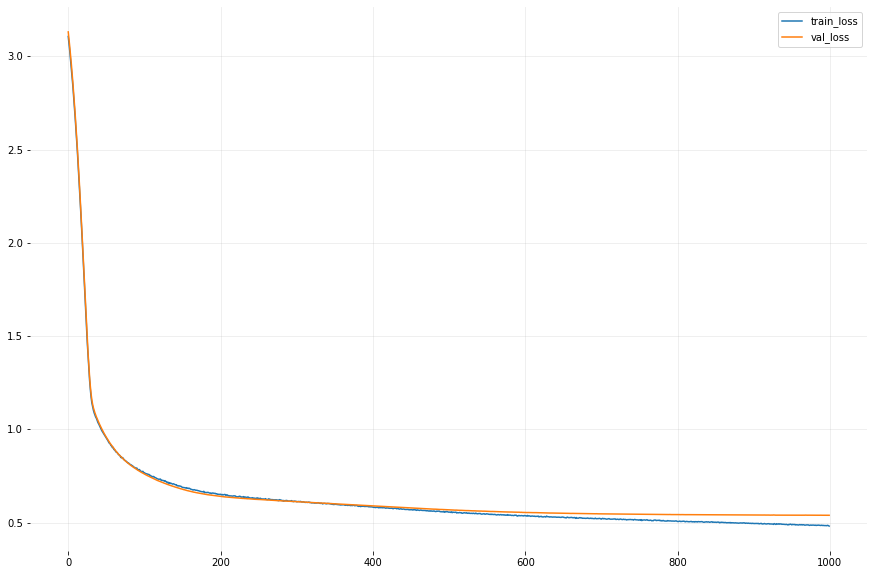

In [348]:
plt.figure(figsize=(15,10))
plt.plot(history.history['loss'], label = 'train_loss')
plt.plot(history.history['val_loss'], label = 'val_loss')
plt.box(False)
plt.grid(True, alpha = .25)
plt.legend()
plt.show()

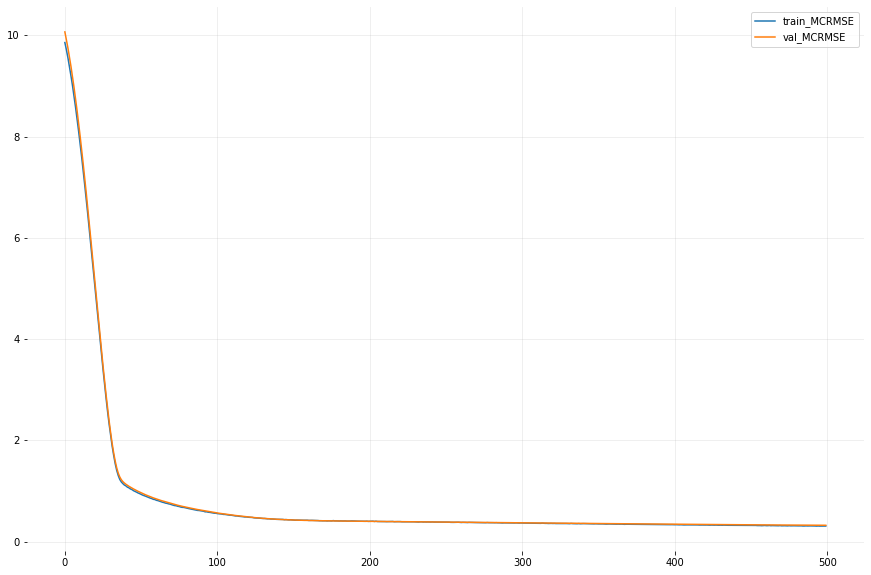

In [342]:
plt.figure(figsize=(15,10))
plt.plot(history.history['mse'], label = 'train_MCRMSE')
plt.plot(history.history['val_mse'], label = 'val_MCRMSE')
plt.box(False)
plt.grid(True, alpha = .25)
plt.legend()
plt.show()

In [28]:
model = tf.keras.models.load_model('embeddings_scratch.keras', custom_objects={'MCRMSE':MCRMSE})

In [29]:
eval = model.evaluate(padded_test, Y_test)
eval

2022-09-19 09:35:26.025202: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8100
2022-09-19 09:35:26.637899: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory


7/7 [==============================] - 2s 2ms/step - loss: 0.6112 - mse: 0.3781


2022-09-19 09:35:27.194223: I tensorflow/stream_executor/cuda/cuda_blas.cc:1786] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


[0.6112228035926819, 0.3780919313430786]

In [30]:
y_pred = model.predict(padded_test)

7/7 [==============================] - 0s 862us/step


In [34]:
MCRMSE(Y_test, y_pred).numpy()

0.6135743274599891

In [142]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Embedding(input_dim = max_tokens, output_dim = 64, input_length = 1000),    
    tf.keras.layers.GRU(64, return_sequences=True),
    tf.keras.layers.GRU(64, return_sequences=True),
    tf.keras.layers.GRU(32, return_sequences=True),
    tf.keras.layers.GRU(32, return_sequences=False),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(6)
])

In [143]:
model.compile(loss = MCRMSE, metrics = 'mse', optimizer = tf.keras.optimizers.RMSprop(lr = 1e-4))

/home/hdd_n/mambaforge/envs/tf_env/lib/python3.10/site-packages/keras/optimizers/optimizer_v2/rmsprop.py:135: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(RMSprop, self).__init__(name, **kwargs)


In [144]:
model.summary()

Model: "sequential_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_13 (Embedding)    (None, 1000, 64)          1280000   
                                                                 
 gru_14 (GRU)                (None, 1000, 64)          24960     
                                                                 
 gru_15 (GRU)                (None, 1000, 64)          24960     
                                                                 
 gru_16 (GRU)                (None, 1000, 32)          9408      
                                                                 
 gru_17 (GRU)                (None, 32)                6336      
                                                                 
 flatten_13 (Flatten)        (None, 32)                0         
                                                                 
 dense_13 (Dense)            (None, 6)               

In [145]:
callbacks = [
    tf.keras.callbacks.ModelCheckpoint("embeddings_scratch.keras", save_best_only=True), 
    tf.keras.callbacks.EarlyStopping(
        monitor='val_loss',
        patience = 10)
]

In [146]:
history = model.fit(
    x = padded_train, 
    y = Y_train, 
    validation_data = (padded_valid, Y_valid),
    callbacks = callbacks,
    epochs = 100)

Epoch 1/100
98/98 [==============================] - 11s 94ms/step - loss: 2.7155 - mse: 7.5921 - val_loss: 1.7674 - val_mse: 3.2542
Epoch 2/100
98/98 [==============================] - 9s 90ms/step - loss: 1.2227 - mse: 1.6399 - val_loss: 0.9334 - val_mse: 0.9128
Epoch 3/100
98/98 [==============================] - 9s 90ms/step - loss: 0.7829 - mse: 0.6390 - val_loss: 0.7010 - val_mse: 0.5034
Epoch 4/100
98/98 [==============================] - 9s 89ms/step - loss: 0.6638 - mse: 0.4503 - val_loss: 0.6529 - val_mse: 0.4333
Epoch 5/100
98/98 [==============================] - 9s 89ms/step - loss: 0.6496 - mse: 0.4295 - val_loss: 0.6491 - val_mse: 0.4282
Epoch 6/100
98/98 [==============================] - 9s 91ms/step - loss: 0.6485 - mse: 0.4283 - val_loss: 0.6490 - val_mse: 0.4280
Epoch 7/100
98/98 [==============================] - 9s 91ms/step - loss: 0.6456 - mse: 0.4243 - val_loss: 0.6456 - val_mse: 0.4237
Epoch 8/100
98/98 [==============================] - 9s 90ms/step - loss: 0

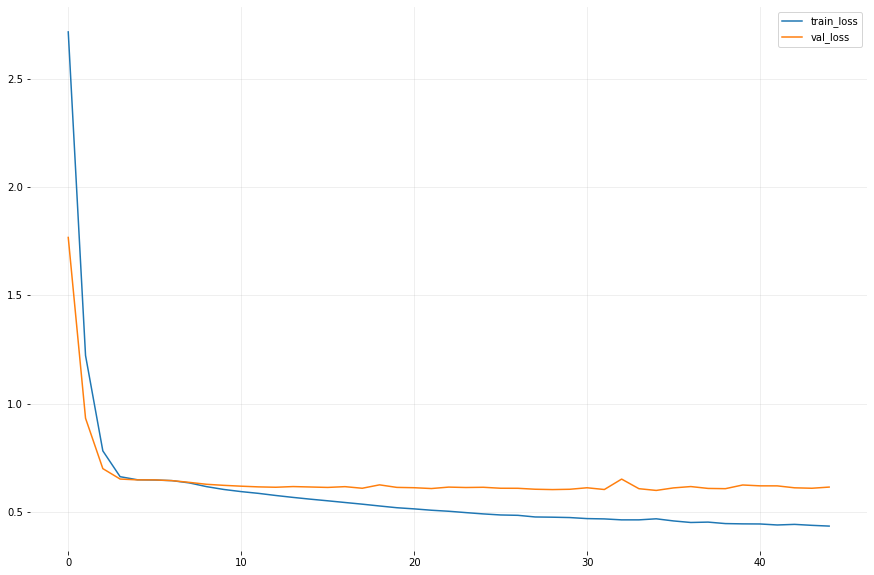

In [147]:
plt.figure(figsize=(15,10))
plt.plot(history.history['loss'], label = 'train_loss')
plt.plot(history.history['val_loss'], label = 'val_loss')
plt.box(False)
plt.grid(True, alpha = .25)
plt.legend()
plt.show()

In [14]:
# !wget http://nlp.stanford.edu/data/glove.6B.zip
# !unzip -q glove.6B.zip

In [48]:
from tqdm import tqdm
from tensorflow.keras.initializers import Constant

In [35]:
glove_path = './glove.6B.300d.txt'

In [63]:
max_tokens = 18_000

In [64]:
tokenizer = Tokenizer(num_words= max_tokens)
tokenized_train = tokenizer.texts_to_sequences(X_train.full_text)
tokenized_valid = tokenizer.texts_to_sequences(X_valid.full_text)
tokenized_test = tokenizer.texts_to_sequences(X_test.full_text)

In [65]:
padded_train = pad_sequences(sequences=tokenized_train, maxlen = 1000)
padded_valid = pad_sequences(sequences=tokenized_valid, maxlen = 1000)
padded_test = pad_sequences(sequences=tokenized_test, maxlen = 1000)

In [66]:
padded_train.shape, padded_valid.shape, padded_test.shape

((3128, 1000), (587, 1000), (196, 1000))

In [67]:
embeddings_index = {}
with open(glove_path) as f:
    for line in f:
        word, coefs = line.split(maxsplit=1)
        coefs = np.fromstring(coefs, 'f', sep = ' ')
        embeddings_index[word] = coefs

print(f"Word vector count: {len(embeddings_index)}")

Word vector count: 400000


In [68]:
num_words = len(tokenizer.word_index)
embedding_matrix = np.zeros((max_tokens, 300))

In [69]:
for word, i in tqdm(tokenizer.word_index.items()):
    if i < num_words:
        vect = embeddings_index.get(word, [])
        if len(vect) > 0:
            embedding_matrix[i] = vect[:300]

0it [00:00, ?it/s]


In [70]:
embedding_matrix.shape

(18000, 300)

In [122]:
# inputs: A 3D tensor, with shape [batch, timesteps, feature].
model = tf.keras.models.Sequential([
    tf.keras.layers.Embedding(
        input_dim = max_tokens, 
        output_dim = 300,
        embeddings_initializer = Constant(embedding_matrix),
        input_length = 1000,
        trainable = False),
    tf.keras.layers.GRU(64, return_sequences=True),
    tf.keras.layers.GRU(64, return_sequences=True),
    tf.keras.layers.GRU(32, return_sequences=False),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(6)
])

In [123]:
model.compile(loss = MCRMSE, metrics = 'mse', optimizer = tf.keras.optimizers.RMSprop(lr = 1e-4))

/home/hdd_n/mambaforge/envs/tf_env/lib/python3.10/site-packages/keras/optimizers/optimizer_v2/rmsprop.py:135: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(RMSprop, self).__init__(name, **kwargs)


In [124]:
model.summary()

Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_11 (Embedding)    (None, 1000, 300)         5400000   
                                                                 
 gru_8 (GRU)                 (None, 1000, 64)          70272     
                                                                 
 gru_9 (GRU)                 (None, 1000, 64)          24960     
                                                                 
 gru_10 (GRU)                (None, 32)                9408      
                                                                 
 flatten_11 (Flatten)        (None, 32)                0         
                                                                 
 dense_11 (Dense)            (None, 6)                 198       
                                                                 
Total params: 5,504,838
Trainable params: 104,838
Non

In [125]:
callbacks = [
    tf.keras.callbacks.ModelCheckpoint("embeddings_scratch.keras", save_best_only=True), 
    tf.keras.callbacks.EarlyStopping(
        monitor='val_loss',
        patience = 50)
]

In [126]:
history = model.fit(
    x = padded_train, 
    y = Y_train, 
    validation_data = (padded_valid, Y_valid),
    callbacks = callbacks,
    epochs = 50)

Epoch 1/50
98/98 [==============================] - 9s 79ms/step - loss: 2.8847 - mse: 8.4474 - val_loss: 2.1668 - val_mse: 4.9505
Epoch 2/50
98/98 [==============================] - 7s 76ms/step - loss: 1.4002 - mse: 2.3047 - val_loss: 1.0407 - val_mse: 1.2126
Epoch 3/50
98/98 [==============================] - 7s 76ms/step - loss: 0.8471 - mse: 0.7684 - val_loss: 0.7238 - val_mse: 0.5325
Epoch 4/50
98/98 [==============================] - 7s 76ms/step - loss: 0.6719 - mse: 0.4595 - val_loss: 0.6527 - val_mse: 0.4329
Epoch 5/50
98/98 [==============================] - 8s 77ms/step - loss: 0.6497 - mse: 0.4297 - val_loss: 0.6495 - val_mse: 0.4288
Epoch 6/50
98/98 [==============================] - 7s 76ms/step - loss: 0.6494 - mse: 0.4292 - val_loss: 0.6493 - val_mse: 0.4286
Epoch 7/50
98/98 [==============================] - 7s 74ms/step - loss: 0.6498 - mse: 0.4292 - val_loss: 0.6493 - val_mse: 0.4285
Epoch 8/50
98/98 [==============================] - 7s 74ms/step - loss: 0.6487 - m

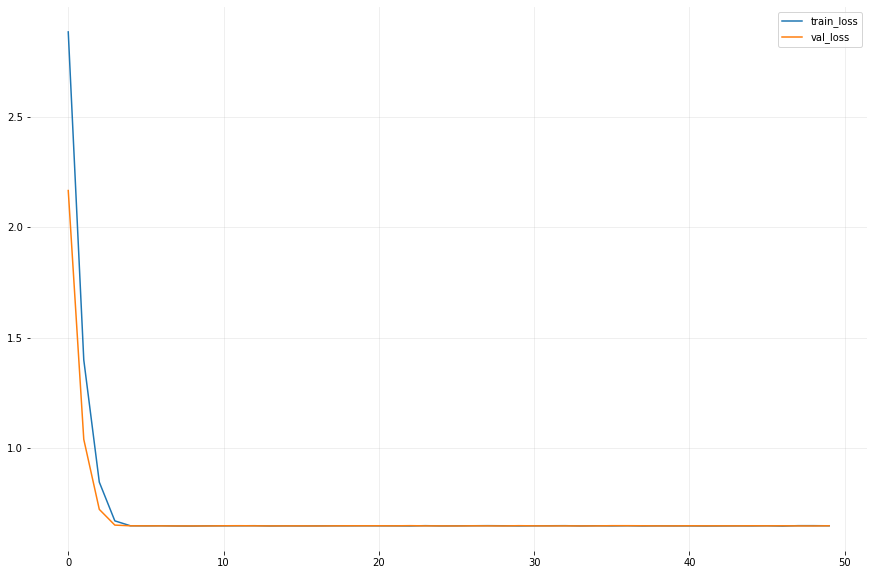

In [127]:
plt.figure(figsize=(15,10))
plt.plot(history.history['loss'], label = 'train_loss')
plt.plot(history.history['val_loss'], label = 'val_loss')
plt.box(False)
plt.grid(True, alpha = .25)
plt.legend()
plt.show()